In [1]:
%%time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from raw_data import utils
import pdb

CPU times: user 364 ms, sys: 56 ms, total: 420 ms
Wall time: 417 ms


In [2]:
class MetaClassConfig:
    def __init__(self, name, aesth_lists, max_imgs=None):
        self.name = name
        self.aesth_lists = aesth_lists
        self.max_imgs = max_imgs

In [3]:
meta_class_configs = [
    MetaClassConfig('small_generic', ['generic_ls_train.jpgl', 'generic_ss_train.jpgl', 'generic_test.jpgl'], 100),
    MetaClassConfig('portraits', ['portrait_test.jpgl', 'portrait_train.jpgl']),
    MetaClassConfig('generic', ['generic_ls_train.jpgl', 'generic_ss_train.jpgl', 'generic_test.jpgl']),
]

In [4]:
def load_ava_df():
    return pd.read_csv('raw_data/AVA_dataset/AVA.txt', sep=' ', 
                     names=['id', 1,2,3,4,5,6,7,8,9,10, 'tag1', 'tag2', 'challenge'])

In [5]:
import functools
def process_df(df):
    """
    Creates and returns a copy of the dataframe with the addition of 
    • file name
    • score (weighted mean of the votes)
    • standard deviation
    • normalized score
    • normalized standard deviation
    • randomly splits it into train/test sets 80-20
    """
    # Deep copy
    df = df.copy()
    
    # Drop unused columns
    df = df.drop(columns=['tag1', 'tag2', 'challenge'])
    
    # File name
    df['file_name'] = df['id'].astype(str) + '.png'
    
    # Calculate mean score
    votes = np.zeros(len(df))
    score = np.zeros(len(df))
    for i in range(1, 11):
        votes += df[i]
        score += i * df[i]

    df['score'] = score / votes
    
    # Calculate sum of square differences between scores and mean score
    squared_difference = np.zeros(df.shape[0])
    for i in range(1, 11):
        squared_difference += df[i] * ((df['score'] - i)**2)
    
    # Standard deviation
    df['std'] = np.sqrt(squared_difference / votes)
    
    # Normalize score
    df['norm_score'] = (df['score'] - df['score'].mean()) / df['score'].std()
    
    # Normalize std
    df['norm_std'] = (df['std'] - df['std'].mean()) / df['std'].std()
    
    df['subset'] = None
    
    # Get the top 10% and lowest 10% and classify them as beautiful and ugly
    data_size = len(df)
    ten_perc_size = data_size // 10
    
    beautiful_df = df.nlargest(ten_perc_size, 'score')
    ugly_df = df.nsmallest(ten_perc_size, 'score')
    df['class'] = None
    df.loc[df.index.isin(beautiful_df.index), 'class'] = 'beautiful'
    df.loc[df.index.isin(ugly_df.index), 'class'] = 'ugly'
    
    # Split into train and test
    class_types = df['class'].unique()
    train_dfs = []
    for class_type in class_types:
        class_df = df[df['class'] == class_type] if class_type is not None else df[pd.isna(df['class'])]
        train_df = class_df.sample(frac=0.8)
        train_dfs.append(train_df)
    
    train = functools.reduce(lambda x, y: x.merge(y, how='outer'), train_dfs)
    
    df.loc[df.index.isin(train.index), 'subset'] = 'train'    
    df.loc[pd.isna(df['subset']), 'subset'] = 'test'
    
    return df

In [6]:
ava_df = load_ava_df()
ava_df.sample(4)

id  1   2   3   4   5   6   7   8  9  10  tag1  tag2  challenge
15191   537723  5   4  13  49  39   8   1   1  0   1    16     0        696
191588  234157  2   6  11  34  69  56  28  13  5   3     0     0        380
67041   138590  0   0   7  13  55  80  41  21  6   0    15    24        301
232186  654113  8  18  24  59  63  30  17   5  4   1     1     6        825

In [7]:
processed_ava_df = process_df(ava_df)
processed_ava_df.sample(4)

id   1   2   3   4   5   6   7   8   9  10   file_name     score  \
159511  114305   4   7  42  82  76  23   3   0   0   1  114305.png  4.289916   
168305  273153   0   6   9  31  67  91  56  29  10  11  273153.png  6.025806   
18018   154798  14  31  29  55  64  48  36  21   8   8  154798.png  4.977707   
142716  837096   5   5  10  31  78  47  19   7   0   2  837096.png  5.147059   

             std  norm_score  norm_std subset class  
159511  1.154086   -1.495171 -1.353494  train  ugly  
168305  1.612245    0.878552  0.900292  train  None  
18018   2.098562   -0.554659  3.292594  train  None  
142716  1.447764   -0.323081  0.091173  train  None

In [7]:
from skimage.transform import rescale
def resize_and_trim_to_aspect_ratio(image, size):
    """
    Trims the edges such that the image meets the aspect ratio of the size and the image is centered, 
    and then scales it down to the size
    :param image:
    :param size:
    :return:
    """

    center = (image.shape[0] // 2, image.shape[1] // 2)
    row_factor = image.shape[0] / size[0]
    column_factor = image.shape[1] / size[1]

    limiting_factor = min(row_factor, column_factor)

    cropped_size = (int(size[0] * limiting_factor), int(size[1] * limiting_factor))

    image = image[center[0] - (cropped_size[0] // 2) : center[0] + (cropped_size[0] // 2), 
                  center[1] - (cropped_size[1] // 2) : center[1] + (cropped_size[1] // 2)]

    image = rescale(image, min(size[0] / image.shape[0], size[1] / image.shape[1]), 
                    anti_aliasing=True, preserve_range=True, multichannel=True, mode='reflect').astype('uint8')

    return image

In [8]:
import os
import shutil
from PIL import Image
def gen_meta_class_data(df, name):
    new_dir = 'processed_data/{}/'.format(name)
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.makedirs(new_dir)
    
    df.to_csv(new_dir + 'df.csv', index=False)
    
    # Plot samples
    plt.figure(figsize=(20, 20))
    plt.title('Samples')
    
    sorted_df = df.sort_values(by='norm_score')
    num_rows = len(sorted_df)
    interval = int(num_rows / 16)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        done = False
        for j, row in sorted_df[interval * i: interval * (i + 1)].iterrows():
            image_id = int(row['id'])
            
            # It's possible that the image may not exist
            try:
                img = Image.open('raw_data/AVA_dataset/images/all_images/{}.jpg'.format(image_id)).convert('RGB')
                img_array = np.asarray(img)
                img_array = resize_and_trim_to_aspect_ratio(img_array, (256, 256))
                plt.imshow(img_array)
                plt.xlabel('{} | {}'.format(round(row['norm_score'], 3), round(row['norm_std']), 3))
                # Successfully loaded an image. Move on to the next
                break
            except Exception as e:
                print(e)
                pass
    plt.savefig(new_dir + 'samples.png')
    
    # Plot score and std distribution
    plt.figure()
    with sns.axes_style("white"):
        sns.jointplot(x="norm_score", y="norm_std", data=df, kind='hex', color='k')
    plt.savefig(new_dir + 'val_distr.png')
    
    

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 15.7 s, sys: 280 ms, total: 16 s
Wall time: 16.1 s


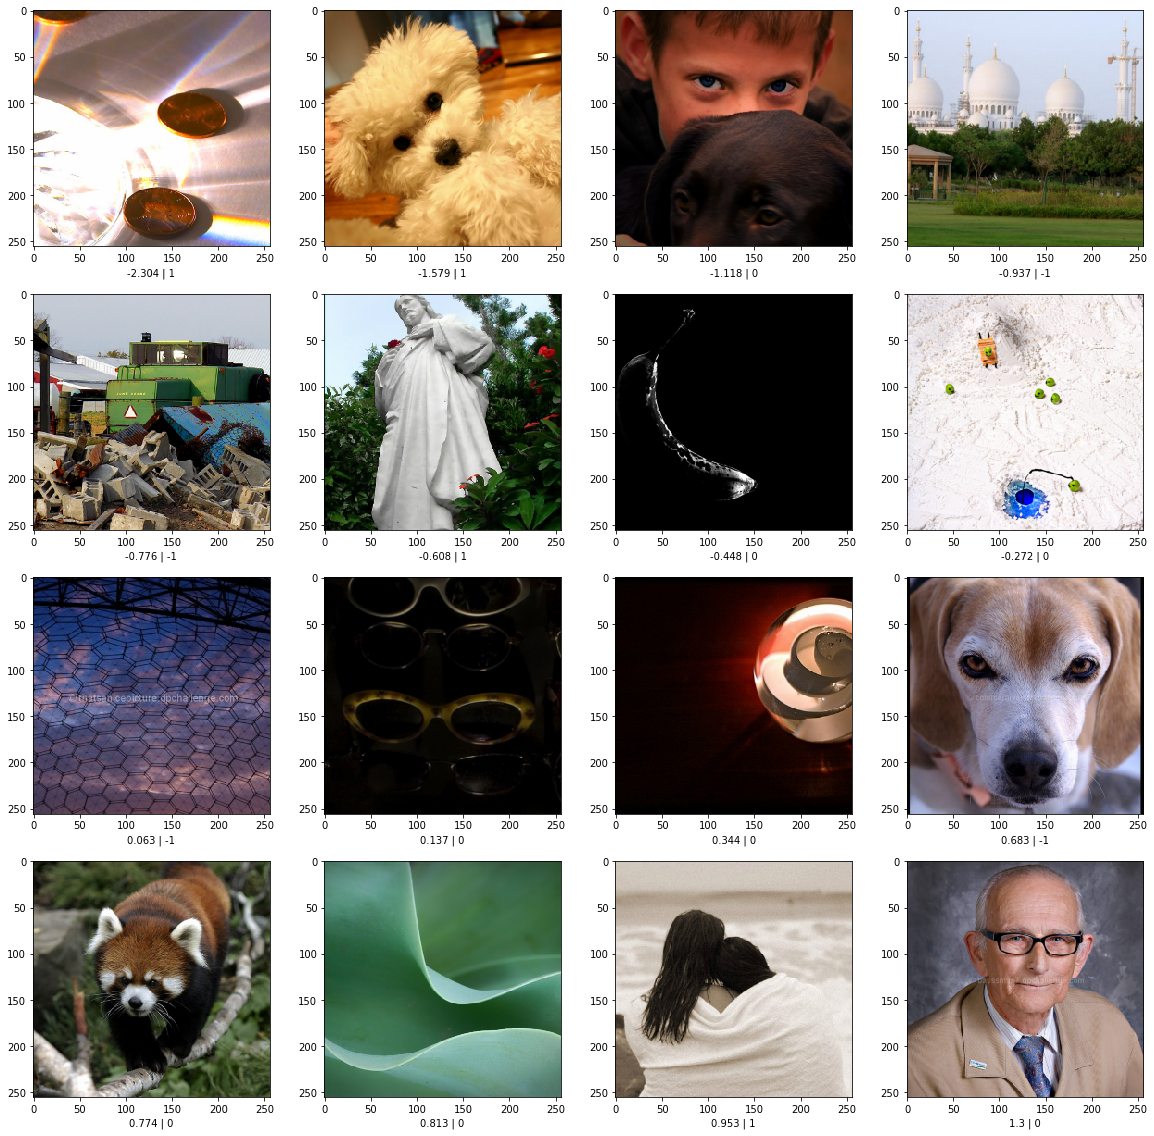

<Figure size 432x288 with 0 Axes>

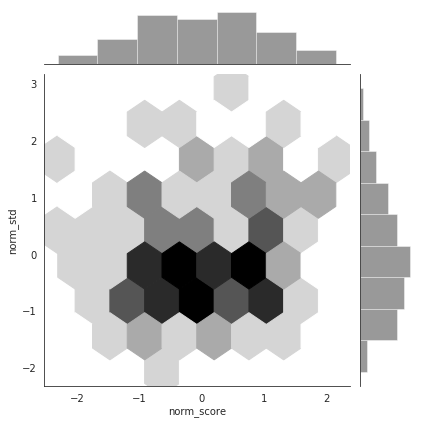

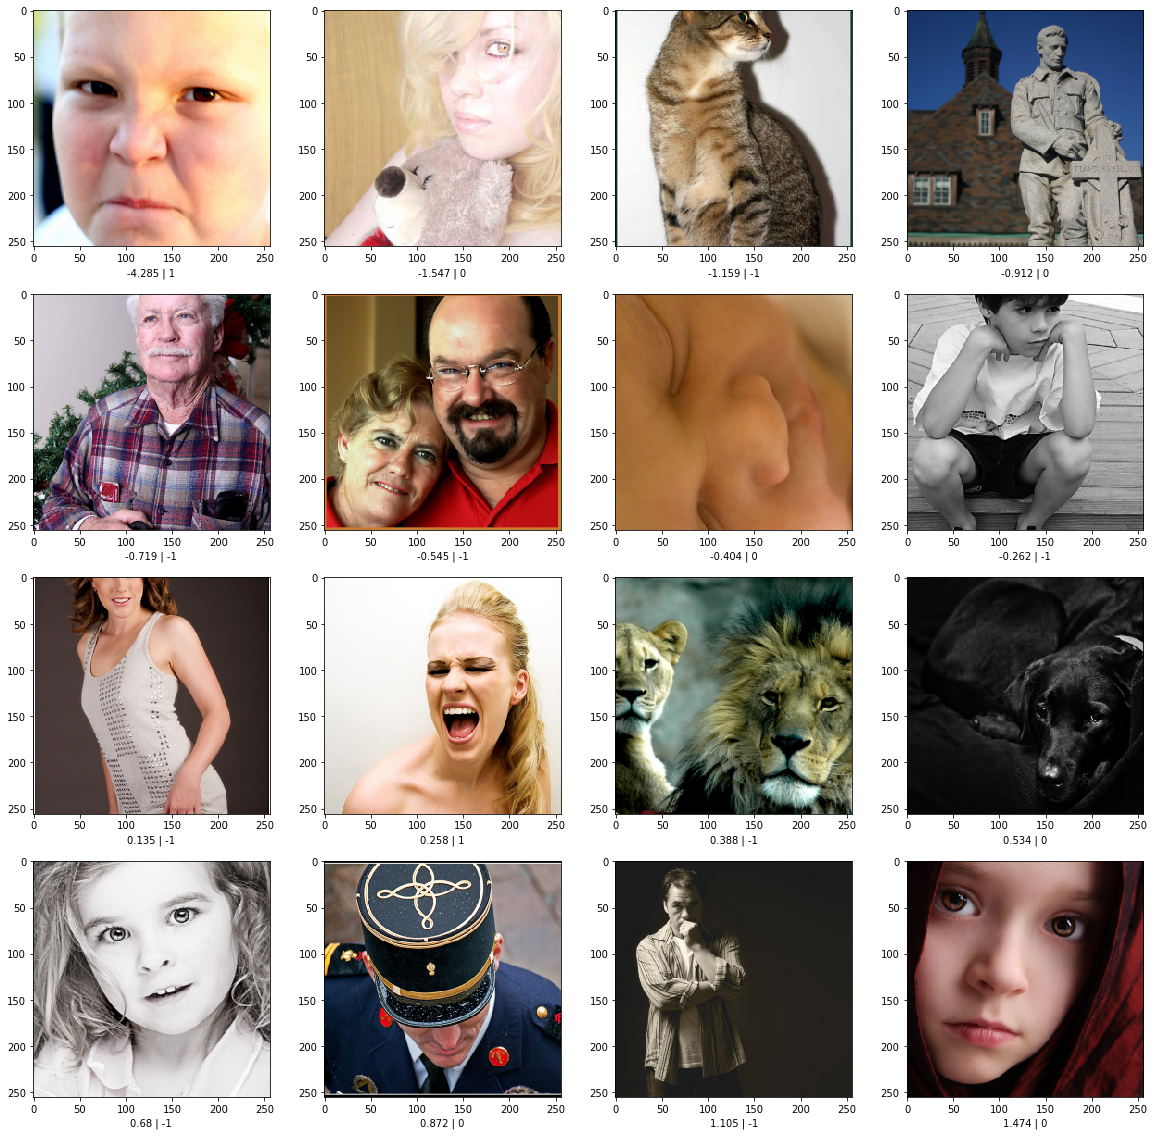

<Figure size 432x288 with 0 Axes>

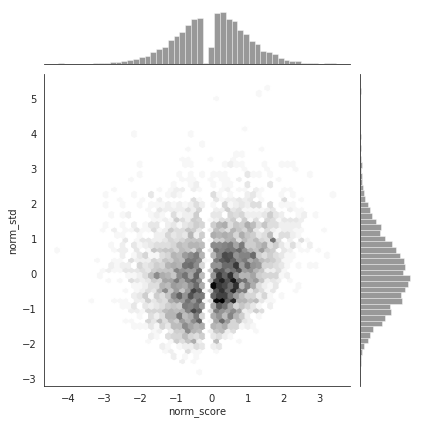

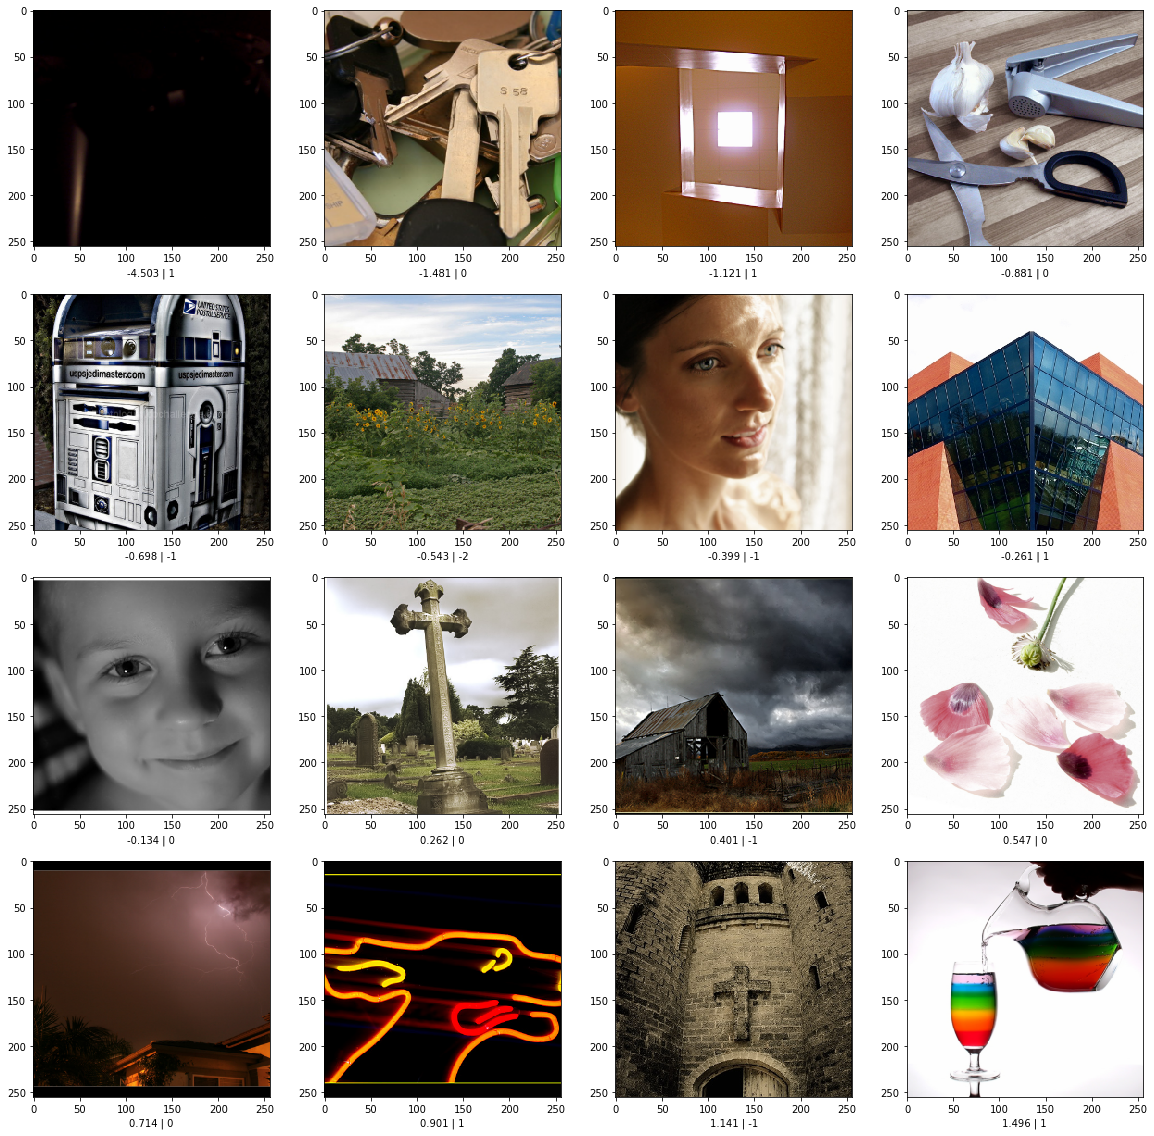

<Figure size 432x288 with 0 Axes>

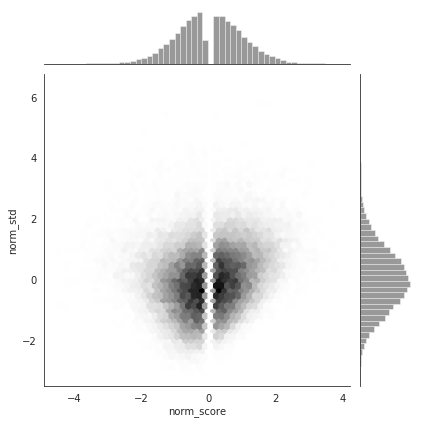

In [9]:
%%time
for mc_config in meta_class_configs:
    ava_df = load_ava_df()
    
    curr_df = pd.DataFrame(columns=[0])
    for aesth_list in mc_config.aesth_lists:
        df = pd.read_csv('raw_data/AVA_dataset/aesthetics_image_lists/{}'.format(aesth_list), header=None)
        curr_df = curr_df.merge(df, 'outer')
    
    if mc_config.max_imgs is not None:
        curr_df = curr_df.sample(mc_config.max_imgs)
    
    num_imgs = len(curr_df)
    
    curr_df = ava_df.merge(curr_df, left_on='id', right_on=0)
    
    curr_df = curr_df.drop(columns=[0])
    
    curr_df = process_df(curr_df)
    
    gen_meta_class_data(curr_df, mc_config.name)
    

In [10]:
def write_images(df, output_directory, new_size):
    """
    Writes all images in a dataframe to an output directory
    """
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)
    
    num_imgs_missing = 0
    
    for i, row in df.iterrows():
        image_id = int(row['id'])
        input_file_path = 'raw_data/AVA_dataset/images/all_images/{}.jpg'.format(image_id)
        output_file_path = '{}/{}.png'.format(output_directory, image_id)

        if os.path.exists(output_file_path):
            continue

        try:
            img = Image.open(input_file_path).convert('RGB')
            img_array = np.asarray(img)
            img_array = resize_and_trim_to_aspect_ratio(img_array, new_size)
            img = Image.fromarray(img_array, mode="RGB")
            img.save(output_file_path)
        except Exception as e:
            num_imgs_missing += 1
    print('{} missed images'.format(num_imgs_missing))

In [11]:
import os
import pandas as pd
def make_img_pool(shape):
    meta_classes = os.listdir('processed_data/')
    meta_classes = list(filter(lambda name: '.' not in name and name != 'image_pool', meta_classes))
    empty_df = pd.DataFrame(columns=[0])
    
    output_path = 'processed_data/image_pool/{}_{}/'.format(shape[0], shape[1])
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
        
    for meta_class in meta_classes:
        df = pd.read_csv('processed_data/{}/df.csv'.format(meta_class))
        write_images(df, output_path, shape)

In [13]:
%%time
make_img_pool((256, 256))

2 missed images
5 missed images
0 missed images
CPU times: user 9.27 s, sys: 496 ms, total: 9.77 s
Wall time: 9.95 s
